In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude

In [187]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_PB/dark')
count = 0
output_df_pooled = pd.DataFrame()
output_bump_amplitude_pooled = pd.DataFrame()
output_PVA_strength_pooled = pd.DataFrame()
for single_df in os.listdir(pooled_directory):
    current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
    #Get time info
    volume_cycle = len(current_file )
    volume_time = current_file['Time_Stamp'][1]
    volume_rate = 1/volume_time
    time_array_imaging = np.arange(volume_cycle)/volume_rate
    #Get necessary parameters
    PVA_Unwrapped_Radian = current_file['Unwrapped_Radian']
    PVA_Angle = current_file['PVA_Angle']
    Angular_velocity = current_file['Angular_Velocity']
    integrated_x = current_file['Integrated_x']
    PVA_strength = current_file['PVA_strength']
    Bump_amplitude = current_file['Bump_amplitude']
    Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading']
    
    dff_normalized_8_roi = np.zeros((len(current_file['dFF_Roi_1']), 8))
    for i in range(len(current_file['F_Roi_1'])):
        dff_normalized_8_roi[i,0]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi[i,1]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi[i,2]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi[i,3]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi[i,4]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi[i,5]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi[i,6]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi[i,7]= current_file['dFF_Roi_8'][i]
    
    #Need no series array for function below 
    PVA_Unwrapped_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Angle_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Angular_velocity_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    integrated_x_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_strength_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Bump_amplitude_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Unwrapped_heading_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    for i in range(len(current_file['Unwrapped_Radian'])):
        PVA_Unwrapped_Radian_no_series[i] = current_file['Unwrapped_Radian'][i]
        PVA_Angle[i] = current_file['PVA_Angle'][i]
        PVA_Angle_no_series[i] = current_file['PVA_Angle'][i]
        Angular_velocity_no_series[i] = current_file['Angular_Velocity'][i]
        integrated_x_no_series[i] = current_file['Integrated_x'][i]
        PVA_strength_no_series[i] = current_file['PVA_strength'][i]
        Bump_amplitude_no_series[i] = current_file['Bump_amplitude'][i]
        Unwrapped_heading_no_series[i] = current_file['Unwrapped_Bar_Position/Heading'][i]
    
    integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
    Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
    Forward_speed_radian = np.abs(Forward_velocity)
    Forward_speed_degrees =Forward_speed_radian * 180/np.pi
    
    #Get persistence period
    persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
    #Calculate annd plot difference throughout the stop period
    difference_during_stop = []
    current_difference_during_stop = []
    current_forward_speed_during_stop = []
    forward_speed_during_stop =[]
    #plt.figure(figsize= (25,7))
    for current_index in range(len(persistence_stop_index_and_length)):
        current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
        current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
        current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
        current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
        #Modify the value so angle difference will never be different more than 180 degrees
        for j in range(len(current_difference_during_stop)):
            if np.abs(current_difference_during_stop[j]) > 180:
                if current_difference_during_stop[j] < 0:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                else:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
        difference_during_stop.append(current_difference_during_stop)
        forward_speed_during_stop.append(current_forward_speed_during_stop)
    
    bump_amplitude_stopping_duration = 5
    minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time))
    #200ms bin size
    bump_amplitude_stopping_bin_size = 0.2
    
    #gaussian smooth and z-score the Bump Amplitude/PVA Strength Array as in Fisher, Marquis 2022
    #Bump_amplitude_gaussian_smooth = gaussian_filter1d(Bump_amplitude, sigma =3)
    Bump_amplitude_gaussian_smooth = gaussian_filter1d(np.max(dff_normalized_8_roi,axis=1), sigma =3)
    PVA_strength_gaussian_smooth = gaussian_filter1d(PVA_strength, sigma =3)
    
    stopping_period_PVA_strength_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 5,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =PVA_strength_gaussian_smooth)
    bump_amplitude_stopping_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 5,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =Bump_amplitude_gaussian_smooth)
    stopping_period_bump_amp_current = pd.DataFrame(bump_amplitude_stopping_current.transpose())
    stopping_period_PVA_strength_current = pd.DataFrame(stopping_period_PVA_strength_current.transpose())
    if count == 0:
        output_bump_amplitude_pooled = stopping_period_bump_amp_current
        output_PVA_strength_pooled =  stopping_period_PVA_strength_current
    else:
        output_bump_amplitude_pooled = pd.concat([output_bump_amplitude_pooled,stopping_period_bump_amp_current],ignore_index=True, axis =1)
        output_PVA_strength_pooled = pd.concat([output_PVA_strength_pooled,stopping_period_PVA_strength_current],ignore_index=True, axis =1)
    
    
    PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
    single_trial_info = single_df.split("-")
    flytrial = [single_trial_info[0], single_trial_info[1]]
    PVA_angle_at_stop.insert(0,'FlyTrial',"-".join(flytrial))
    PVA_angle_at_stop.insert(1,'Genotype','R60D05>GCaMP7f')
    PVA_angle_at_stop.insert(2,'TrialType','dark')
    Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
    Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
    output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
    
    if count == 0:
        output_df_pooled = output_df
    else:
        output_df_pooled = pd.concat([output_df_pooled,output_df], ignore_index=True)
    
    count = count + 1

In [188]:
output_bump_amplitude_pooled_percentage = output_bump_amplitude_pooled.copy()
for i in range(len(output_bump_amplitude_pooled_percentage.mean(axis=0))):
    output_bump_amplitude_pooled_percentage[i] = output_bump_amplitude_pooled_percentage[i]/output_bump_amplitude_pooled_percentage[i][0]

In [189]:
len(output_bump_amplitude_pooled_percentage.mean(axis=0))

159

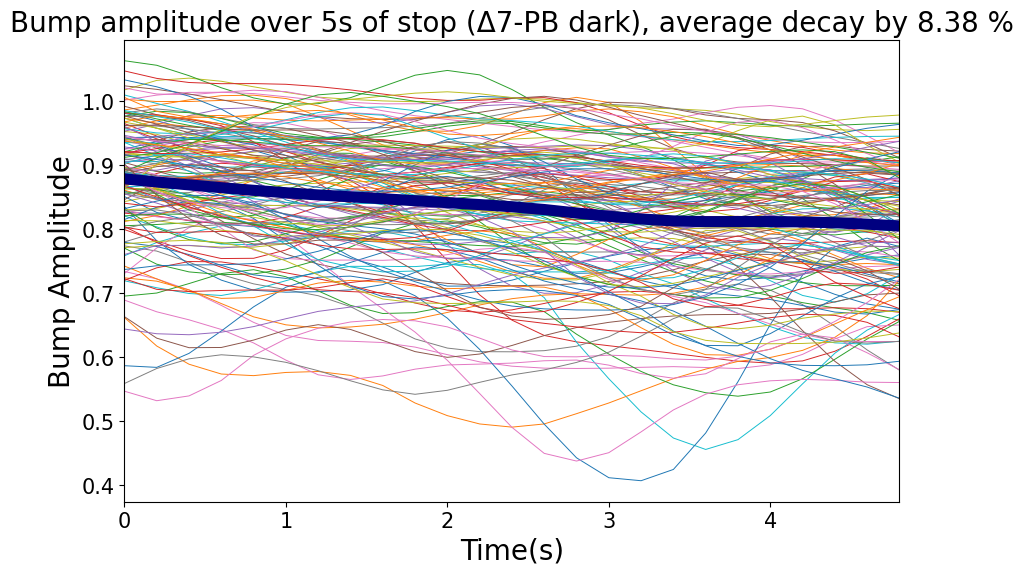

In [190]:
average_decay_Bump_a = round((output_bump_amplitude_pooled.mean(axis=1)[0]-output_bump_amplitude_pooled.mean(axis=1)[24])/output_bump_amplitude_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_amplitude_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_amplitude_pooled.columns)):
    plt.plot(time_array_decay,output_bump_amplitude_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_amplitude_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,4.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude over 5s of stop (Δ7-PB dark), average decay by {average_decay_Bump_a} %",fontsize =20)
plt.show()


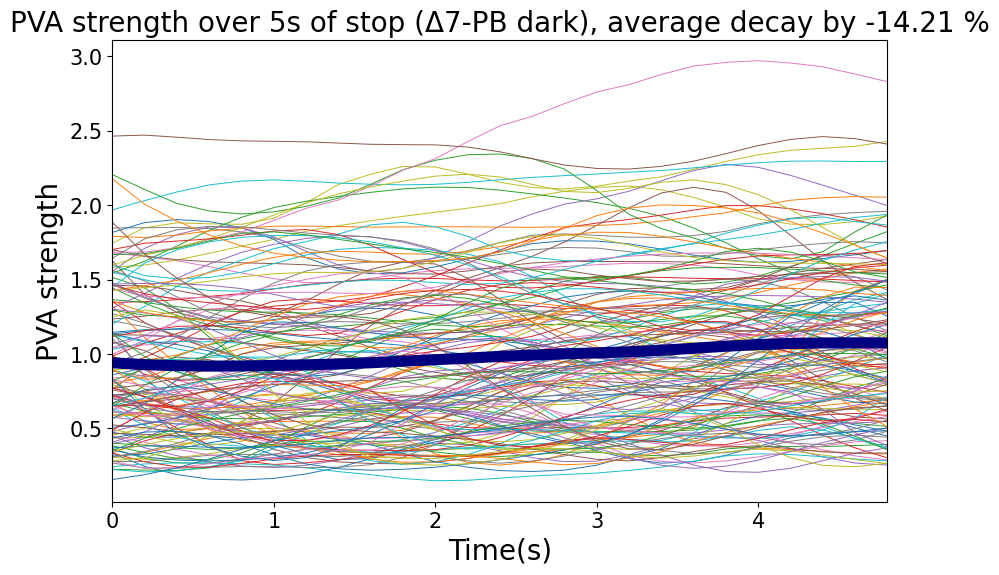

In [182]:
average_decay_PVA_S = round((output_PVA_strength_pooled.mean(axis=1)[0]-output_PVA_strength_pooled.mean(axis=1)[24])/output_PVA_strength_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_PVA_strength_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_PVA_strength_pooled.columns)):
    plt.plot(time_array_decay,output_PVA_strength_pooled[i], linewidth = 0.7)
plt.plot(time_array_decay,output_PVA_strength_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,4.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('PVA strength', fontsize=20)
plt.title(f"PVA strength over 5s of stop (Δ7-PB dark), average decay by {average_decay_PVA_S} %",fontsize =20)
plt.show()

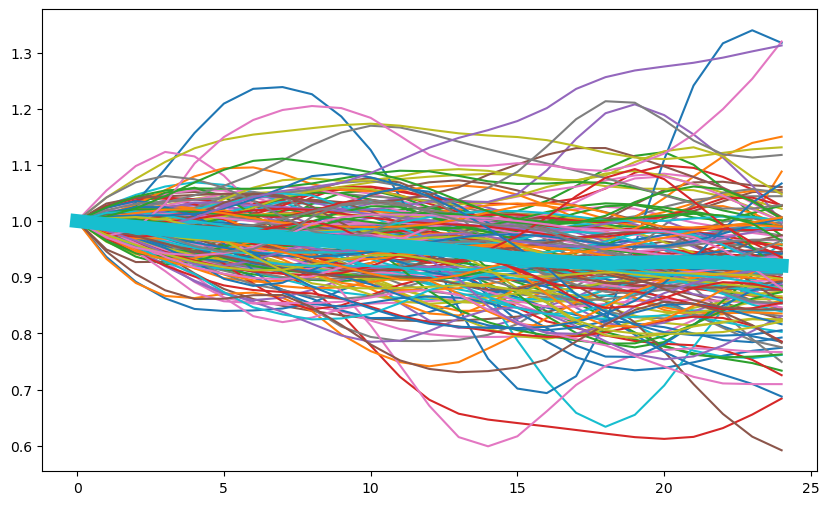

In [191]:
time_array_decay = np.arange(len(output_bump_amplitude_pooled_percentage.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_amplitude_pooled_percentage.columns)):
    plt.plot(output_bump_amplitude_pooled_percentage[i])
plt.plot(output_bump_amplitude_pooled_percentage.mean(axis=1), linewidth=10)
plt.show()

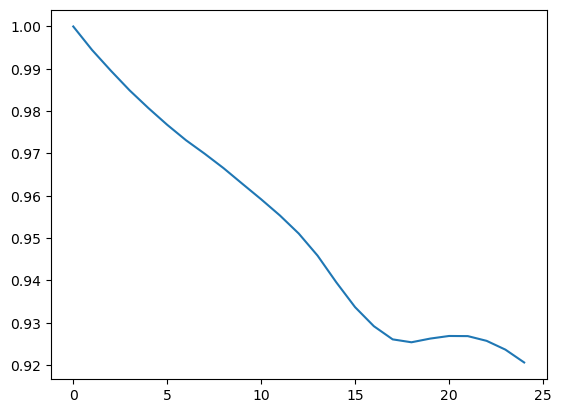

In [192]:
plt.plot(output_bump_amplitude_pooled_percentage.mean(axis=1))
plt.show()

In [182]:
bump_amplitude_stopping_duration = 3
#200ms bin size
bump_amplitude_stopping_bin_size = 0.2
bump_amplitude_stopping_bin_number =int(bump_amplitude_stopping_duration/bump_amplitude_stopping_bin_size)
bump_amplitude_stopping_current = np.zeros((len(persistence_stop_index_and_length),bump_amplitude_stopping_bin_number ))
bins_amplitude = []
for low in range (0, int(0+100*bump_amplitude_stopping_bin_size*bump_amplitude_stopping_bin_number),int(100*bump_amplitude_stopping_bin_size)):
    bins_amplitude.append((low, int(low+bump_amplitude_stopping_bin_size*100)))
for current_index in range(len(persistence_stop_index_and_length)):
    start_index = [persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1][0]
    temp_amplitude = 0
    temp_count = 0
    bin_index = 0
    for current_binduration_index in range(int(np.ceil(bump_amplitude_stopping_duration/volume_time))):
        if current_binduration_index == int(np.ceil(bump_amplitude_stopping_duration/volume_time)) - 1:
            if current_binduration_index * volume_time * 100 >= bins_amplitude[bin_index][0] and current_binduration_index * volume_time * 100 < bins_amplitude[bin_index][1]:
                temp_amplitude = temp_amplitude + Bump_amplitude[start_index+current_binduration_index]
                temp_count = temp_count + 1
                bump_amplitude_stopping_current[current_index, bin_index] = temp_amplitude/temp_count
            else:
                bump_amplitude_stopping_current[current_index, bin_index] = temp_amplitude/temp_count
                temp_amplitude = Bump_amplitude[start_index+current_binduration_index]
                temp_count = 1
                bin_index = bin_index + 1
                bump_amplitude_stopping_current[current_index, bin_index] = temp_amplitude/temp_count
        elif current_binduration_index * volume_time * 100>= bins_amplitude[bin_index][0] and current_binduration_index * volume_time * 100< bins_amplitude[bin_index][1]: 
            temp_amplitude = temp_amplitude + Bump_amplitude[start_index+current_binduration_index]
            temp_count = temp_count + 1
        else:
            bump_amplitude_stopping_current[current_index, bin_index] = temp_amplitude/temp_count
            temp_amplitude = Bump_amplitude[start_index+current_binduration_index]
            temp_count = 1
            bin_index = bin_index + 1
            

In [238]:
stopping_period_bump_amp_current = pd.DataFrame(bump_amplitude_stopping_current.transpose())
stopping_period_bump_amp_current_2 =pd.DataFrame(bump_amplitude_stopping_current.transpose())
pd.concat([stopping_period_bump_amp_current,stopping_period_bump_amp_current_2 ], ignore_index=True, axis =1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.100533,0.475033,0.133474,0.102890,0.154474,0.083306,0.076603,0.196787,0.525057,0.100533,0.475033,0.133474,0.102890,0.154474,0.083306,0.076603,0.196787,0.525057
1,0.134891,0.559216,0.133564,0.150811,0.139891,0.118954,0.111320,0.204380,0.360439,0.134891,0.559216,0.133564,0.150811,0.139891,0.118954,0.111320,0.204380,0.360439
2,0.088502,0.640459,0.071423,0.121017,0.163863,0.123505,0.099706,0.166363,0.361441,0.088502,0.640459,0.071423,0.121017,0.163863,0.123505,0.099706,0.166363,0.361441
3,0.120902,0.599181,0.087763,0.105847,0.127988,0.111190,0.100137,0.171768,0.416354,0.120902,0.599181,0.087763,0.105847,0.127988,0.111190,0.100137,0.171768,0.416354
4,0.149109,0.363569,0.119455,0.109974,0.117798,0.093281,0.109371,0.192507,0.438680,0.149109,0.363569,0.119455,0.109974,0.117798,0.093281,0.109371,0.192507,0.438680
5,0.259683,0.405232,0.101736,0.140486,0.089689,0.086513,0.077912,0.235519,0.427156,0.259683,0.405232,0.101736,0.140486,0.089689,0.086513,0.077912,0.235519,0.427156
6,0.301318,0.474070,0.127259,0.144875,0.102631,0.094670,0.063488,0.222892,0.430298,0.301318,0.474070,0.127259,0.144875,0.102631,0.094670,0.063488,0.222892,0.430298
7,0.269412,0.526276,0.091599,0.079849,0.107374,0.099078,0.097473,0.174271,0.407292,0.269412,0.526276,0.091599,0.079849,0.107374,0.099078,0.097473,0.174271,0.407292
8,0.274769,0.652033,0.088058,0.098684,0.127295,0.087206,0.118809,0.207076,0.476518,0.274769,0.652033,0.088058,0.098684,0.127295,0.087206,0.118809,0.207076,0.476518
9,0.274498,0.704355,0.116563,0.179143,0.104637,0.116577,0.092406,0.209591,0.465447,0.274498,0.704355,0.116563,0.179143,0.104637,0.116577,0.092406,0.209591,0.465447


In [208]:
output_df_pooled

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,...,bump_amplitude_before_stop,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop,bump_amplitude_35s_after_stop
0,TQfly005-003,R60D05>GCaMP7f,dark,11.54830,-49.956023,18.022649,4.083600,-81.673717,-106.000719,-108.935740,...,0.625622,0.330029,0.158781,0.252740,0.376202,0.354858,0.347714,0.321823,0.417692,NaN
1,TQfly005-003,R60D05>GCaMP7f,dark,7.33066,-127.545049,-159.834864,-150.493244,-116.351461,-122.198438,-109.811578,...,0.369000,0.476285,0.475923,0.568869,0.364571,0.546932,0.371878,0.333701,NaN,NaN
2,TQfly005-003,R60D05>GCaMP7f,dark,4.82016,144.160817,-152.306095,-159.530394,-171.463229,-138.003828,-156.727487,...,0.474397,0.725187,0.649987,0.415713,0.554762,0.535421,0.501668,NaN,NaN,NaN
3,TQfly005-003,R60D05>GCaMP7f,dark,3.91638,166.254201,-56.272790,-63.810626,-147.045168,-160.691478,-160.691478,...,0.358707,0.465723,0.406588,0.444574,0.624359,0.624359,0.404300,NaN,NaN,NaN
4,TQfly005-003,R60D05>GCaMP7f,dark,4.61932,-141.065274,-109.955322,-104.858325,-92.554557,171.919204,-178.969742,...,0.405941,0.684539,0.665508,0.324000,0.290532,0.564459,0.365427,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,TQfly020-006,R60D05>GCaMP7f,dark,7.63192,70.660791,112.306443,60.544451,141.664724,53.914719,92.669840,...,0.163005,0.086763,0.108832,0.086233,0.150126,0.070798,0.066121,0.059369,NaN,NaN
142,TQfly020-006,R60D05>GCaMP7f,dark,4.01680,157.346097,75.467665,105.693914,-23.712140,157.476189,76.338413,...,0.090853,0.064236,0.093543,0.082595,0.112136,0.102606,0.102226,NaN,NaN,NaN
143,TQfly020-006,R60D05>GCaMP7f,dark,22.89576,104.504346,14.140901,10.652967,23.826540,-59.320296,12.091455,...,0.067393,0.162819,0.208300,0.224191,0.057072,0.159472,0.090675,0.091808,0.079870,NaN
144,TQfly020-006,R60D05>GCaMP7f,dark,7.23024,7.585169,13.067191,15.906762,18.602958,10.343267,32.271368,...,0.190377,0.320170,0.310791,0.344311,0.179574,0.196981,0.183215,0.084963,NaN,NaN


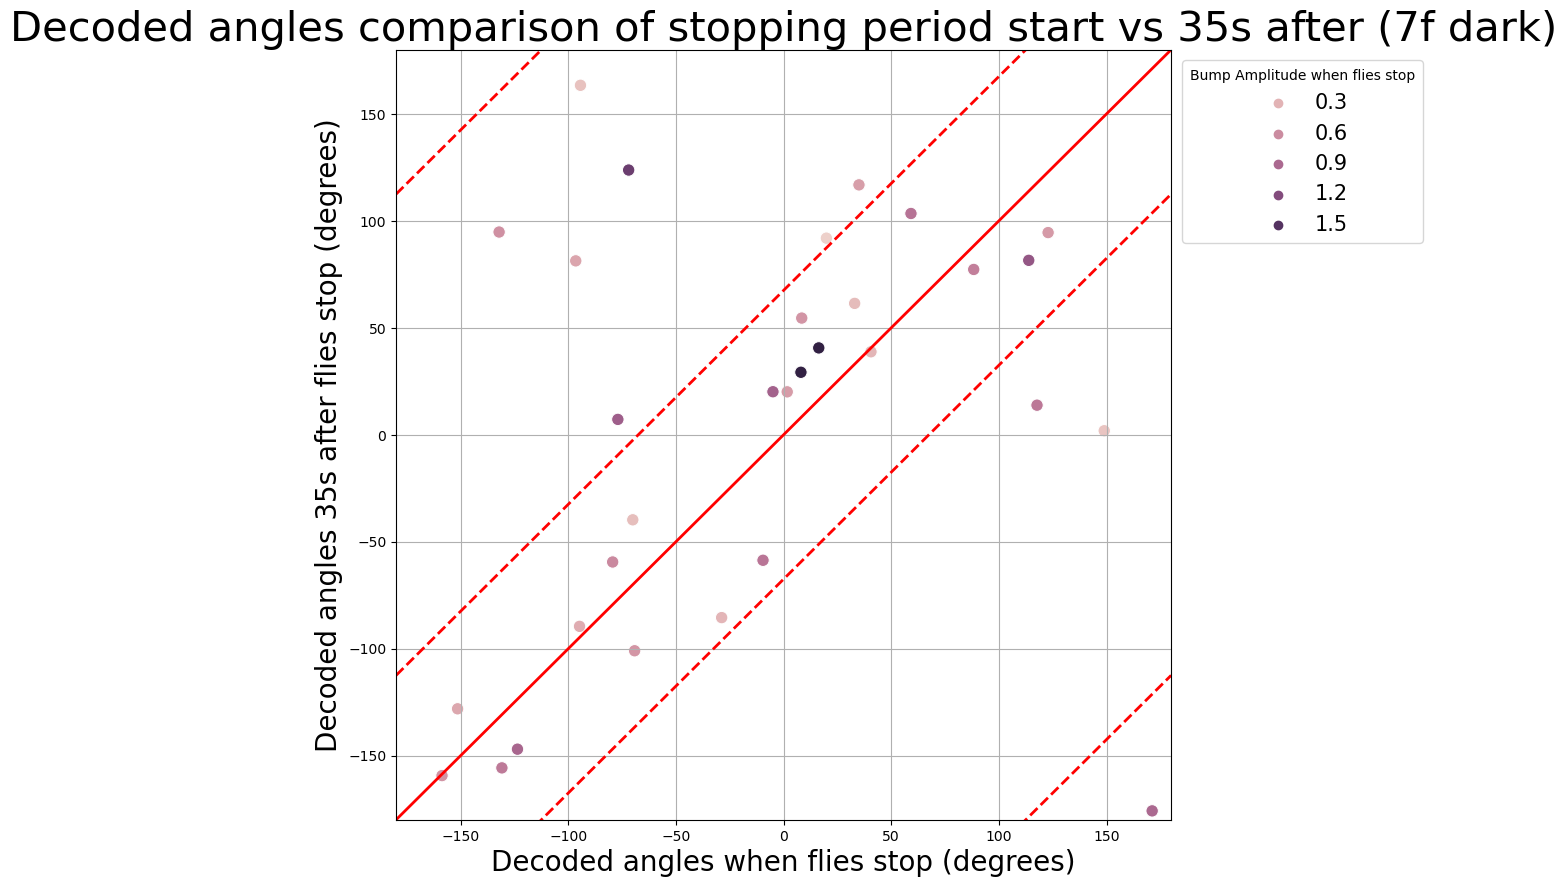

In [80]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_35s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Decoded angles comparison of stopping period start vs 35s after (7f dark)', fontsize =30)
plt.ylabel('Decoded angles 35s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()
#a.savefig('E-PG_Bump_Angle_35s_after_dark', format ='svg')

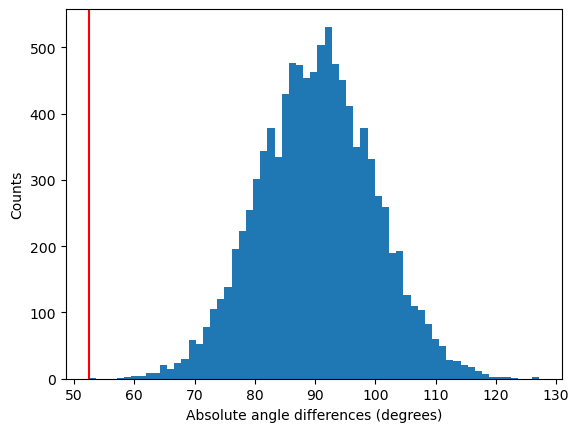

In [84]:
dark_stop_period_start_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)))
dark_stop_period_end_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)
for i in range(len(dark_stop_period_start_35s )):
    dark_stop_period_start_35s[i] = output_df_pooled['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_35s[i] =  output_df_pooled['PVA_35s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_35s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_35s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_35s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_35s ,dark_stop_period_end_35s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     
    
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()

In [85]:
actual_mean_absolute_angle_diff_dark     

52.449256606553796

In [97]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.0005)

52.66366712801736